In this tutorial, we will illustrate ProSRS algorithm for advanced users. We will use the same 2D function as that in ``basic_general.ipynb``:
<img width="354" alt="demo_function" src="https://user-images.githubusercontent.com/8780593/53434522-71f49500-39bc-11e9-81e1-a0f2121dbb37.png">
where $\epsilon$ is normally distributed with mean 0 and standard deviation 0.1. 

Compared to the basic usage as shown in ``basic_general.ipynb``, more details under the hood of the ``optimizer.run()`` method will be revealed in this tutorial. This detailed piece of information will allow users to have finer control over the algorithm, which could be of particular interest to those, who have the needs that cannot be fulfilled by the default method. For example, some users may want to use [MPI](https://en.wikipedia.org/wiki/Message_Passing_Interface) for parallel evaluations rather than using the default ``map`` method in the [pathos](https://pypi.org/project/pathos/) package.

In [1]:
import prosrs
import numpy as np
from multiprocessing import Pool

In [2]:
# Define the function that will be optimized over
def f(x):
    """
    Args:
        
        x (1d array): Function input.
    
    Returns:
    
        y (float): Function output.
    """
    sd = 0.1
    y = x[0]**2+x[1]**2+np.random.normal(0, sd)
    return y

In [3]:
# Define optimization prblem
name = 'Advanced_Demo_1' # problem name
domain = [(-5., 5.), (-5., 5.)] # function domain
x_var = ['x', 'y'] # independent variable names
y_var = 'z' # response variable name
prob = prosrs.Problem(domain, func=f, name=name, x_var=x_var, y_var=y_var) # create problem object
print(prob) # show problem info

Optimization problem:
- Name: Advanced_Demo_1
- Dimension: 2
- Domain: {'x': (-5.0, 5.0), 'y': (-5.0, 5.0)}
- Response variable: 'z'
- Global minimum: unknown
- Global minimum locations: unknown


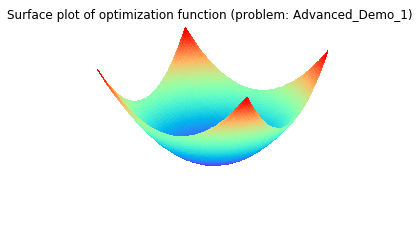

In [4]:
prob.visualize(n_samples=5000, plot='surface') # surface plot of (noisy) function

In [5]:
# Set up optimization (the same as in ``basic_general.ipynb``)
n_worker = 12 # number of workers
n_cycle = 1 # number of optimization cycles
optimizer = prosrs.Optimizer(prob, n_worker, n_cycle=n_cycle) # create optimizer object

In [6]:
# Show optimization configuration
optimizer.show(select=['config'])

Optimization configuration:
- Number of workers: 12
- Termination criterion: stop after completing 1 optimization cycles
- Resuming from the last run?  No
- Output directory: 'out'


In [7]:
# Define customized functions for parallel evaluations
def atomic_eval(arg):
    """
    An atomic evaluation wrapper.
        
    Args:
        
        arg (tuple): Function argument = (f, pt, seed), where
            `f` is function, `pt` is the point to be evaluated,
            and `seed` is the random seed.
        
    Returns:
        
        y (float): Function value.
    """
    f, pt, seed = arg
    np.random.seed(seed)
    y = f(pt)
    return y
    
def parallel_eval(f, pts, seeds):
    """
    Evaluate a function in parallel using `multiprocessing module` <https://docs.python.org/2/library/multiprocessing.html>.
    
    Args:
    
        f (callable): Evaluation function, of which the input is 1d array and the output is float.
        
        pts (2d array): Points to be evaluated. Each element (row) is one point. Shape: (n, d).
        
        seeds (1d array): Random seed for each point in `pts`. Shape: (n,).
    
    Returns:
    
        vals (1d array): Function value for each point in `pts`. Shape: (n,).
        
    Note: 
        
        This function essentially tries to parallelize the following for loop:
        
        vals = np.zeros(0)
        for pt, seed in zip(pts, seeds):
            np.random.seed(seed)
            vals = np.append(vals, f(pt))
    """    
    n = pts.shape[0] # number of points
    p = Pool(n) # create a pool object
    args = [(f, pt, seed) for pt, seed in zip(pts, seeds)]
    vals = np.array(p.map(atomic_eval, args))
    return vals

In [8]:
# Run optimization
while not optimizer.is_done():
    
    print('\nIteration %d:' % (optimizer.i_iter+1))
    
    # propose new points
    new_pt = optimizer.propose(verbose=True)
    
    # evaluate proposed points using customized functions
    new_val = parallel_eval(prob.f, new_pt, optimizer.eval_seeds)
    print('Evaluated proposed points using customized functions.')
    
    # update optimizer state with the new evaluations
    optimizer.update(new_pt, new_val, verbose=True)


Iteration 1:
Proposing new points (DOE) .......... Done (time took: 1.03e-05 sec).
Evaluated proposed points using customized functions.
Updating optimizer state .......... Done (time took: 9.92e-04 sec).

Iteration 2:
Building RBF regression model .......... Done (time took: 3.32e-02 sec).
Proposing new points .......... Done (time took: 3.49e-03 sec).
Evaluated proposed points using customized functions.
Updating optimizer state .......... Done (time took: 2.35e-03 sec).

Iteration 3:
Building RBF regression model .......... Done (time took: 2.90e-02 sec).
Proposing new points .......... Done (time took: 4.79e-03 sec).
Evaluated proposed points using customized functions.
Updating optimizer state .......... Done (time took: 1.83e-03 sec).

Iteration 4:
Building RBF regression model .......... Done (time took: 3.09e-02 sec).
Proposing new points .......... Done (time took: 4.95e-03 sec).
Evaluated proposed points using customized functions.
Updating optimizer state .......... Done (t

In [9]:
# Obtain top 10 points from the optimization, sorted by function values
top_pt, top_val, _ = optimizer.top_pts(n_top=10)
# Display these top 10 points using 'show' method
optimizer.show(select=['result'], n_top=10) 

Optimization result:
- Best point:
  x = 0.0675409, y = 0.0368185
- Best (noisy) value:
  z = -0.267438
- Top 10 points sorted by (noisy) function values (Column 3):
               x            y           z
       0.0675409    0.0368185   -0.267438
       0.0473768    0.0319884   -0.200975
       0.0234784   -0.0618226   -0.200455
     0.000525153    0.0398275   -0.189711
      -0.0307424    0.0257534   -0.175184
     -0.00406293   -0.0992571    -0.16525
       0.0318244   0.00636367   -0.157786
        0.108968    0.0169107   -0.152936
       -0.106274   -0.0133742   -0.137044
        0.161917   0.00381127    -0.13665


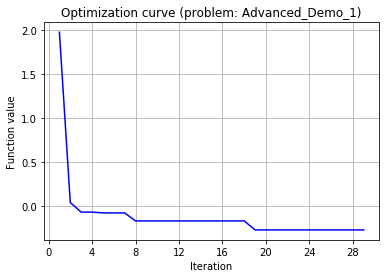

In [10]:
# Visualize optimization results
optimizer.visualize(select=['optim_curve']) # optimization curve

In [11]:
# Perform posterior evaluations
n_top = 100 # use top 100 points as the candidates for the posterior best point
n_repeat = 100 # number of Monte Carlo repeats
optimizer.posterior_eval(n_top=n_top, n_repeat=n_repeat) # run posterior Monte Carlo evaluations

Running posterior evaluations (n_point = 100, n_repeat = 100) .......... Done (time took: 6.75e-01 sec).


In [12]:
# Get optimization results after posterior evaluations
best_point = optimizer.post_best_x # best point found (the one with the lowest Monte Carlo mean estimate)
best_value = optimizer.post_best_y # best value found (the Monte Carlo mean estimate for 'optimizer.post_best_x')
top_pt, top_mean_val, top_std_val, _ = optimizer.post_top_pts(n_top=10) # top 10 points in terms of Monte Carlo mean estimates
# Display these results using 'show' method
optimizer.show(select=['post_result'], n_top=10)

Posterior evaluation results:
- Condition: run ProSRS algorithm for 29 iterations, then run posterior evaluations with 100 Monte Carlo repeats
- Best point:
  x = -0.00398517, y = 0.0188333
- Best (mean) value:
  z = -0.0168467
- Top 10 points sorted by Monte Carlo mean estimates (Column 3):
               x             y     mean of z    std of z
     -0.00398517     0.0188333    -0.0168467     0.10382
        0.052794   -0.00990112     -0.014664   0.0968309
     0.000525153     0.0398275    -0.0105333    0.100591
       0.0291564    0.00948164   -0.00996051    0.108875
      -0.0676148     -0.033974   -0.00731349    0.113011
        0.023577     0.0114009   -0.00713064   0.0882457
       0.0159035     0.0130352   -0.00673901   0.0997713
      -0.0307424     0.0257534   -0.00671296   0.0930354
      -0.0133138   -0.00396448   -0.00552519   0.0986572
      -0.0284368   -0.00717304   -0.00497546    0.099594
